In [1]:
# @title Install dependencies
!pip install jupyterlab-widgets geopandas geoplot
!pip install matplotlib --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
# @title Select the whl file for the wawbus package
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.whl', multiple=False)
display(upload)

FileUpload(value={}, accept='.whl', description='Upload')

In [3]:
# @title upload whl file
for uploaded_filename in upload.value:
  content = upload.value[uploaded_filename]['content']
  with open(uploaded_filename, "w+b") as f:
    f.write(content)

In [4]:
# @title Install the wawbus package
!pip install {list(upload.value.keys())[0]}

Processing ./wawbus-0.0.1-py2.py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1


In [5]:
from wawbus import WawBus
from wawbus.constants import MAX_SPEED

import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import geoplot as gplt

from ipywidgets import Dropdown, Text, VBox, IntSlider

In [6]:
# @title Main api configuration
dataset = Dropdown(options=['20240207-66k', '20240208-140k', 'None'], description='Prefetched dataset')
api_key = Text(description='API key (optional)', placeholder='Enter your API key')
collection = IntSlider(description='How many data points to collect. If zero, only the prefetched dataset will be used', min=0, step=1)
display(VBox([dataset, api_key, collection]))

In [8]:
api = WawBus(apikey=api_key.value, dataset=dataset.value if dataset.value != 'None' else None)

In [9]:
if collection.value > 0:
    api.collect_positions(collection.value)

In [10]:
api.dataset.head()

Lat        Lon                Time Lines VehicleNumber Brigade
0  52.160114  21.207024 2024-02-08 20:35:23   213          1000       1
1  52.190298  21.142564 2024-02-08 20:35:23   219          1001       1
2  52.222999  21.102276 2024-02-08 20:35:27   213          1002       3
3  52.222576  21.102171 2024-02-08 20:35:28   311          1003     502
4  52.234561  21.115568 2024-02-08 18:09:27   225          1004      04

In [11]:
df = api.calculate_speed()
df.head()

Lat        Lon                Time Lines VehicleNumber Brigade  \
0  52.160114  21.207024 2024-02-08 20:35:23   213          1000       1   
1  52.190298  21.142564 2024-02-08 20:35:23   219          1001       1   
2  52.222999  21.102276 2024-02-08 20:35:27   213          1002       3   
3  52.222576  21.102171 2024-02-08 20:35:28   311          1003     502   
4  52.234561  21.115568 2024-02-08 18:09:27   225          1004      04   

       Speed  
0  15.783312  
1  30.680003  
2   0.625148  
3  16.966011  
4        NaN

In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat, crs='EPSG:4326'))
gdf.head()

Lat        Lon                Time Lines VehicleNumber Brigade  \
0  52.160114  21.207024 2024-02-08 20:35:23   213          1000       1   
1  52.190298  21.142564 2024-02-08 20:35:23   219          1001       1   
2  52.222999  21.102276 2024-02-08 20:35:27   213          1002       3   
3  52.222576  21.102171 2024-02-08 20:35:28   311          1003     502   
4  52.234561  21.115568 2024-02-08 18:09:27   225          1004      04   

       Speed                   geometry  
0  15.783312  POINT (21.20702 52.16011)  
1  30.680003  POINT (21.14256 52.19030)  
2   0.625148  POINT (21.10228 52.22300)  
3  16.966011  POINT (21.10217 52.22258)  
4        NaN  POINT (21.11557 52.23456)

In [48]:
speeding = gdf[(gdf.Speed > 50)]

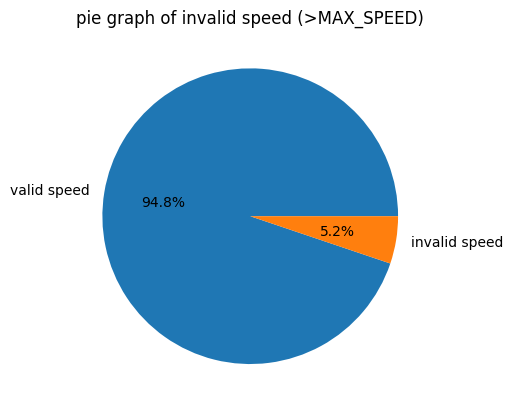

In [49]:
# @title pie graph of invalid speed (>MAX_SPEED)
labels = ['valid speed', 'invalid speed']
speeding['Speed'].apply(lambda x: 1 if x > MAX_SPEED else 0).value_counts().plot.pie(autopct='%1.1f%%', labels=labels)
plt.ylabel('')
plt.title('pie graph of invalid speed (>MAX_SPEED)')
plt.show()

In [50]:
# @title removal of invalid speed entries
speeding = speeding[speeding.Speed <= MAX_SPEED]

In [21]:
# @title 3250 entries of >50km/h interactive map
speeding.head(3250)[['Speed', 'geometry', 'VehicleNumber', 'Lines']].explore(
    column='Speed',
    style_kwds={"style_function":lambda x: {"radius":x["properties"]["Speed"]/5 - 4}}
)

In [22]:
wawmap = gpd.read_file('https://raw.githubusercontent.com/C10udburst/wawbus-data/master/warszawa-dzielnice.geojson')

In [23]:
speed_map = gpd.sjoin(left_df=speeding, right_df=wawmap[['name', 'geometry']], how="left", predicate="intersects")
speed_map = speed_map.drop(columns=['index_right'])
speed_map.head()

Lat        Lon                Time Lines VehicleNumber Brigade  \
12   52.393869  20.898293 2024-02-08 20:35:26   L49         10075       1   
140  52.247527  21.202870 2024-02-08 20:35:17   173          1521       3   
140  52.247527  21.202870 2024-02-08 20:35:17   173          1521       3   
276  52.237503  20.961637 2024-02-08 20:35:27   136          2202       5   
276  52.237503  20.961637 2024-02-08 20:35:27   136          2202       5   

         Speed                   geometry      name  
12   59.647949  POINT (20.89829 52.39387)       NaN  
140  51.966213  POINT (21.20287 52.24753)    Wesoła  
140  51.966213  POINT (21.20287 52.24753)  Warszawa  
276  56.617805  POINT (20.96164 52.23750)  Warszawa  
276  56.617805  POINT (20.96164 52.23750)      Wola

/usr/local/lib/python3.10/dist-packages/geoplot/geoplot.py:1304: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


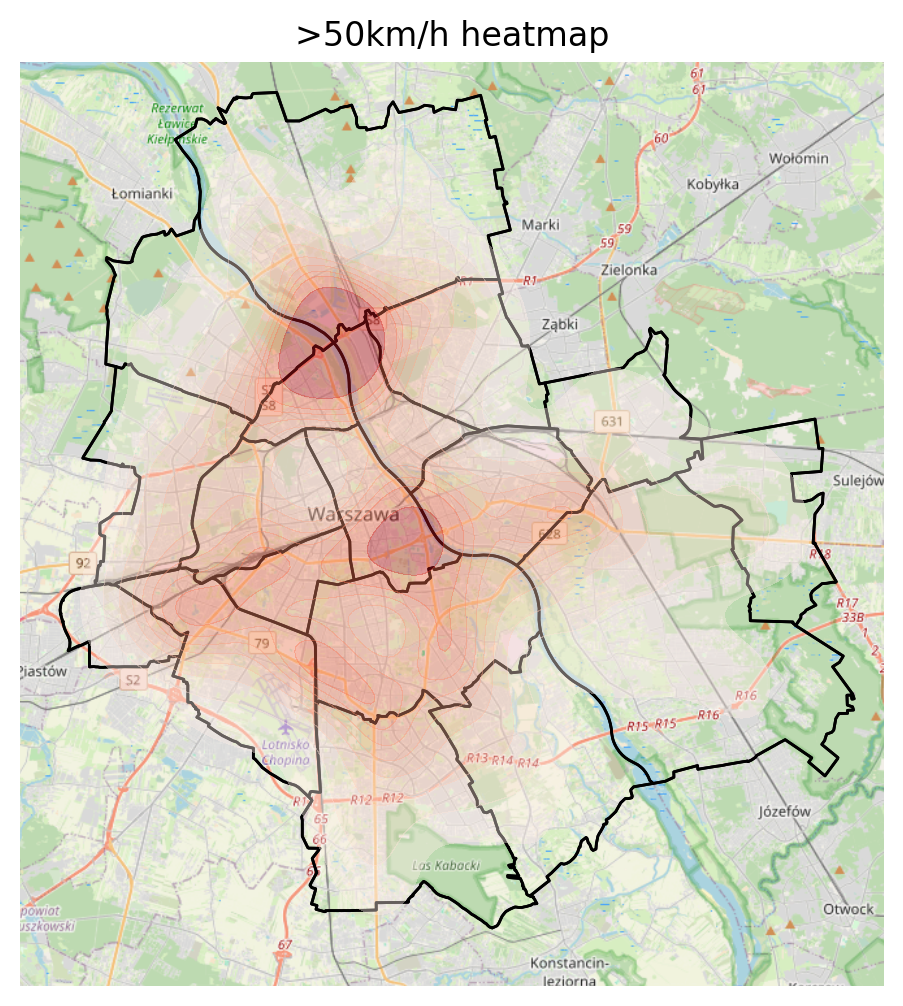

In [42]:
# @title >50km/h heatmap
mpl.rcParams['figure.dpi'] = 200

# we filter to only use entries within Warsaw
speeding_warsaw = speed_map.dropna().geometry

webmap = gplt.webmap(speeding_warsaw, projection=gcrs.WebMercator())
ax = gplt.polyplot(wawmap, projection=gcrs.WebMercator(), zorder=1, ax=webmap)
heatmap = gplt.kdeplot(speeding_warsaw, cmap='Reds', shade=True, ax=ax, projection=gcrs.WebMercator(), alpha=0.4)
plt.title(">50km/h heatmap")
plt.show()

mpl.rcParams['figure.dpi'] = 100

In [25]:
# @title >50 km/h per district counts
speed_map.dropna().groupby('name')['Speed'].count()

name
Bemowo             128
Białołęka          210
Bielany            116
Mokotów            326
Ochota             122
Praga Południe     163
Praga Północ       131
Rembertów           54
Targówek           148
Ursus               52
Ursynów            153
Warszawa          2612
Wawer              211
Wesoła              47
Wilanów             78
Wola               108
Włochy             202
Śródmieście        214
Żoliborz           149
Name: Speed, dtype: int64

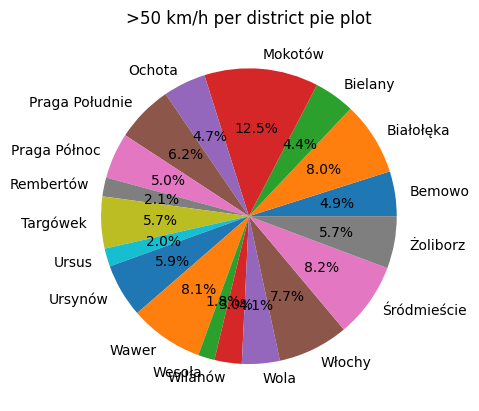

In [43]:
# @title >50 km/h per district pie plot
speed_map[speed_map.name != 'Warszawa'].dropna().groupby('name')['Speed'].count().plot.pie(autopct='%1.1f%%')
plt.title(">50 km/h per district pie plot")
plt.ylabel('')
plt.show()

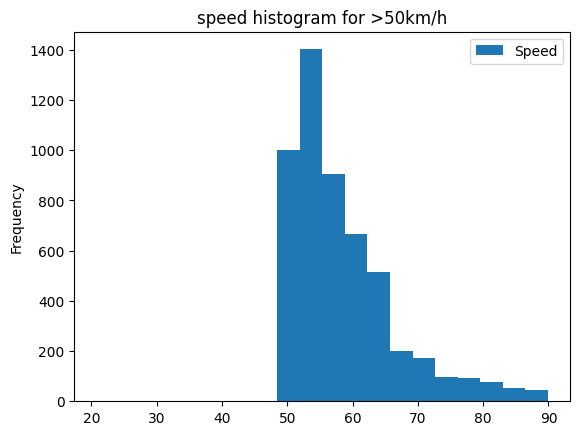

In [44]:
# @title speed histogram for >50km/h
speed_map.dropna().plot.hist(column='Speed', bins=20)
try:
  plt.avxline(speed_map.dropna().mean(), linestyle='dashed', linewidth=1)
except AttributeError:
  pass # ignore old matplotlib error
plt.title("speed histogram for >50km/h")
plt.show()

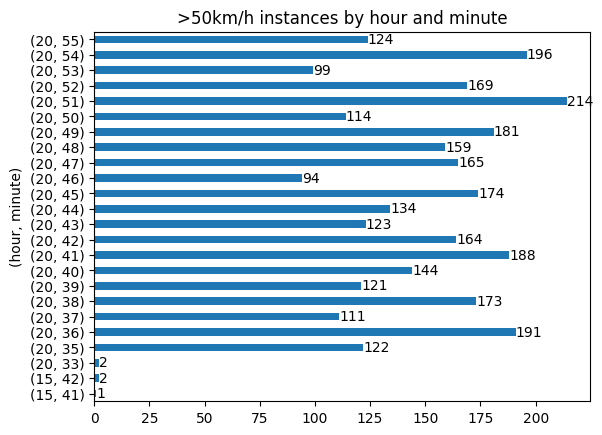

In [45]:
# @title >50km/h instances per hour and minute

ax = speeding.groupby(by=[speeding.Time.map(lambda x : x.hour),
                       speeding.Time.map(lambda x : x.minute)])['Speed'].count().plot.barh()

ax.bar_label(ax.containers[0])

plt.ylabel("(hour, minute)")
plt.title(">50km/h instances by hour and minute")
plt.show()

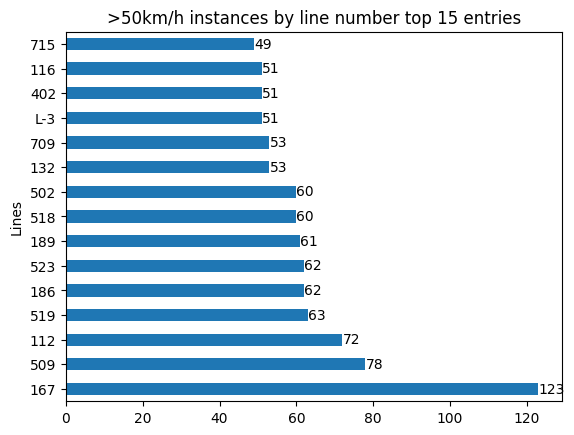

In [46]:
# @title >50km/h instances by line number top 15 entries

ax = speeding.groupby('Lines')['Speed'].count().sort_values(ascending=False).head(15).plot.barh()

ax.bar_label(ax.containers[0])

plt.title(">50km/h instances by line number top 15 entries")
plt.show()